## Learning strategy: Off-policy every-visit MC control, for estimating the optimal policy
The experiment is based on the Exercise 5.12: Racetrack (programming) (Sutton & Barto, p.111) 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Racetrack problem description
In our simplified racetrack, the car is at one of a discrete set of grid positions, and its velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components.
The program includes five parts:
1. Racer Agent, who can choose actions satisfying velocity constraints based on the given policy.
2. Rracetrack Environment, which can initialize state for agent, update its state based on the given action, give reward and so on.
3. Off-policy MC control algorithm.
4. Setting hyperparameters and running algorithm.
5. Plotting.
6. Extra study

### 1 Racecar Agent

In [2]:
class Agent_racer:
    
    # create a velocity-action table, each velocity has a list of possible actions that satisfy constraints
    
    def __init__(self):
        pass
    
    
    def possible_actions(self, velocity):
        
        # All 9 actions:  a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]                            
        # Constraints for velocity:
        # 0 <= v_x < 5
        # 0 <= v_y < 5
        # v_x and v_y cannot be made both zero except for starting
        
        # Using constraints above to filter out invalid actions given the velocity
        # Returns list of possible actions given the velocity
        
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        a = [np.array(x) for x in a]

        possi_a = []
        for i,x in zip(range(9),a):
            new_vel = np.add(velocity,x)
            if (new_vel[0] < 5) and (new_vel[0] >= 0) and (new_vel[1] < 5) and (new_vel[1] >= 0) and ~(new_vel[0] == 0 and new_vel[1] == 0):
                possi_a.append(i)
        possi_a = np.array(possi_a)
        
        return possi_a

    
    def v_a_table(self): 
        
        # create a table to store all the possible actions for each (v_x, v_y)
        # v_x and v_y could be 0,1,2,3,4
        # there are 5x5 = 25 for all (v_x, v_y) combination 
        v_a_table = np.zeros((5,5), dtype=np.ndarray)

        for vx in range(5):
            for vy in range (5):
                v_a_table[vx][vy] = self.possible_actions([vx,vy])
        
        return v_a_table
    
    
    def epsilon_greedy_policy(self, velocity, greedy_action, epsilon=0):
        
        # When epsilon = 0, it will be greedy policy.
        # With probability epsilon, a random action is chosen; 
        # With  probability (1 - epsilon), a maximizing action is chosen.
        s_vx, s_vy = velocity[0], velocity[1]
        cur_a_list = self.v_a_table()[s_vx][s_vy] # current available actions, given vx and vy
        num_actions = len(cur_a_list) # number of all possible actions
        
        # behavior policy b is an epsilon-greedy policy
        if greedy_action in cur_a_list:
            if np.random.rand() >= epsilon:
                a = greedy_action
                prob_a = 1 - epsilon + epsilon/num_actions
            else:
                a = np.random.choice(cur_a_list)
                prob_a = epsilon/num_actions

        else:
            a = np.random.choice(cur_a_list)
            prob_a = 1/num_actions

        a = self.map_to_2D(a)
       
        return a, prob_a                    

    
    def map_to_1D(self,action):
        # transfer 9 actions to integer
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        for i,x in zip(range(9),a):
            if action[0]==x[0] and action[1]==x[1]:
                return i
    
    
    def map_to_2D(self,action):
        # tansfer interger to 9 different actions
        a = [(-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1)]
        return a[action]
    
    

### 2 Racetrack Environment

In [3]:
class Env_racetrack:
    
    # Environment state space: all ([x, y], [v_x, v_y]) combination
    # [x, y] is a cell on our racetrack
    # under the cell [x,y], [v_x, v_y] is horizontal and vertical velocity for the agent racecar

    def __init__(self, course):

        #course is a List of text strings used to construct racetrack
        self.start_positions = []
        
        self.course = None
        self.load_course(course)
#         self._random_start_position()
   
    
    def random_start_position(self):
        
        # randomly choose start position on start line
        self.position = np.array(random.choice(self.start_positions),
                                dtype=np.int16)
   

    def reset(self):
        
        # initialize the racecar agent in the start line with v_x = 0 and v_y = 0
        self.random_start_position()
        self.velocity = np.array([0, 0], dtype=np.int16)
    
    
    def take_action(self, action):
        
        # take action to update current state
        if self.is_terminal_state():
            # if we already cross the finish line, return reward 0 to terminate episode
            return 0
        self.update_velocity(action)
        self.update_position()
        
        # environment return reward to an action, always -1
        return -1
    
    
    def get_state(self):
        
        #after take action to the environment, environment could return new state
        # Return 2-tuple: (position, velocity). Each is a numpy array.
        return (self.position.copy(), self.velocity.copy())
    
    
    def update_velocity(self, action):
        
        # new velocity: [v_x + a_x, v_y + a_y]
        self.velocity += np.array(action, dtype=np.int16)
    
    
    def update_position(self):
        # Update position based on the new velocity
        # Check at each cell from the current position to the update position 
        # If wall is hit, set position to random position at start line 
        # If finish line is crossed, set position to intersect point on finish line.
        max_velocity = 4
        for tstep in range(0, max_velocity+1):
            t = tstep / max_velocity
            pos = self.position + np.round(self.velocity * t).astype(np.int16)
            if self.is_hit_wall(pos):
                self.random_start_position()
                self.velocity = np.array([0, 0], dtype=np.int16)
                return
            if self.is_cross_finish(pos):
                self.position = pos
                self.velocity = np.array([0, 0], dtype=np.int16)
                return
        self.position = pos
     
    
    def load_course(self, course):
        # Load course. Internally represented as numpy array
        y_size, x_size = len(course), len(course[0])
        self.course = np.zeros((x_size, y_size), dtype=np.int16)
        for y in range(y_size):
            for x in range(x_size):
                point = course[y][x]
                if point == 'o':
                    self.course[x, y] = 1
                elif point == '-':
                    self.course[x, y] = 0
                elif point == '+':
                    self.course[x, y] = 2
                elif point == 'W':
                    self.course[x, y] = -1
        # flip left/right so (0,0) is in bottom-left corner
        self.course = np.fliplr(self.course)
        for y in range(y_size):
            for x in range(x_size):
                if self.course[x, y] == 0:
                    self.start_positions.append((x, y))
                    

    def is_hit_wall(self, pos):
        # Return True if position is wall
        return self.course[pos[0], pos[1]] == -1
        

    def is_cross_finish(self, pos):
        # Return True if position is finish line        
        return self.course[pos[0], pos[1]] == 2
    

    def is_terminal_state(self):
        # Return True at episode terminal state
        return (self.course[self.position[0], 
                           self.position[1]] == 2)
    


### 3 Learning algorithm
Off_policy every visit MC Control

In [38]:
def off_policy_MC_control(course, epsilon, episode_num, gamma=1):

    x_size, y_size = len(course[0]), len(course)

    # initialize Q to large negative - otherwise too much exploration
    # 5x5 is dimension of velocity, 3x3 is dimension of action
    Q = np.zeros((x_size, y_size, 5, 5, 3, 3)) - 60 
    C = np.zeros((x_size, y_size, 5, 5, 3, 3)) 
    # pi is our target policy, which is to be improved to optimal one
    pi = np.random.randint(9, size=(x_size, y_size, 5, 5), dtype=np.int16) # randomly initialize target policy pi
    episode_rewards = []

    # generate track, racer object
    track = Env_racetrack(course)
    racer = Agent_racer()

    for e in range(episode_num):
        
        total_reward = 0
        # generate episode following the behavior policy b
        track.reset()
        epi_path = [] # (S0,A0,prob_A0,R1),(S1,A1,prob_A1,R2) ..., RT. prob_A is for update W
        
        while not track.is_terminal_state():
            s = track.get_state()
            s_x, s_y = s[0][0], s[0][1] # current position
            s_vx, s_vy = s[1][0], s[1][1] # current velocity
            
            greedy_action = pi[s_x, s_y, s_vx, s_vy]
            # follow behavior policy b
            a, prob_a = racer.epsilon_greedy_policy((s_vx, s_vy), greedy_action, epsilon)       
        
            r = track.take_action(a)
            total_reward = total_reward + r
            
            epi_path.append((s, a, prob_a, r)) 
            
        episode_rewards.append(total_reward)                
        # update target policy and its Q table
        G = 0
        W = 1
        while len(epi_path) > 0:
            (s, a, prob_a, r) = epi_path.pop() # last in first out
            s_x, s_y = s[0][0], s[0][1]
            s_vx, s_vy = s[1][0], s[1][1]
            a_x, a_y = a
            s_a = (s_x, s_y, s_vx, s_vy, a_x, a_y) #index for state, action combination
            
            G = gamma * G + r
            C[s_a] += W
            Q[s_a] += W / C[s_a] * (G - Q[s_a]) # update Q for target policy with weighted ratio
            
            q_max = -1e6 # initialize a negative impossible Q value
            a_max = -1 # initialize an impossible greedy action 
            for i in range(9):  # given state, find an action that make the Q[s_a] be maximum
                act = racer.map_to_2D(i)
                s_a_max = (s_x, s_y, s_vx, s_vy, act[0], act[1])
                if a_max == -1 or Q[s_a_max] > q_max:
                    a_max = i
                    q_max = Q[s_a_max]
                    
            pi[s_x, s_y, s_vx, s_vy] = a_max # target pi store 1-D action with max Q value
            if pi[s_x, s_y, s_vx, s_vy] != racer.map_to_1D(a):
                break
            else:
                W *= 1/prob_a
                
    
    
    return pi, track, racer, episode_rewards

### 4 Setting parameters and algorithm run

In [5]:
# Race Track (the smaller one) from Sutton and Barto Figure 5.6

racetrack_course =   ['WWWWWWWWWWWWWWWWWW',
                      'WWWWooooooooooooo+',
                      'WWWoooooooooooooo+',
                      'WWWoooooooooooooo+',
                      'WWooooooooooooooo+',
                      'Woooooooooooooooo+',
                      'Woooooooooooooooo+',
                      'WooooooooooWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WoooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWooooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWoooooooWWWWWWWW',
                      'WWWWooooooWWWWWWWW',
                      'WWWWooooooWWWWWWWW',
                      'WWWW------WWWWWWWW']


In [47]:
# setting parameters
course = racetrack_course
epsilon = 0.1
episode_num = 50000
gamma = 0.9

pi, track, racer, episode_rewards = off_policy_MC_control(course, epsilon, episode_num, gamma=gamma)

### 5 Plotting optimal path

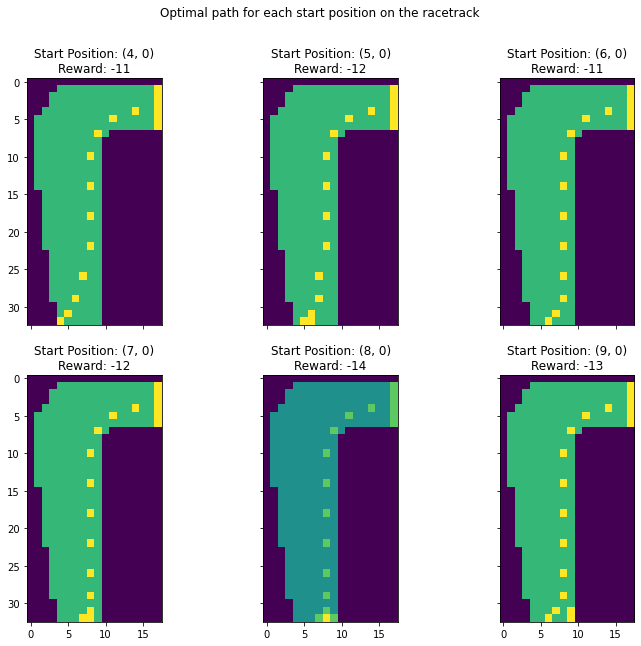

In [58]:
course = racetrack_course
x_size, y_size = len(course[0]), len(course)

fig, ax = plt.subplots(nrows=2, ncols=3, 
                       sharex=True, sharey=True,
                       figsize=(12,10))

for i,start_pos in enumerate(track.start_positions):
    G = 0 # total reward
    track.reset() 
    track.position = np.array(start_pos, dtype=np.int16) # set position to start_pos
    pos_map = np.zeros((x_size, y_size))
    # set all start positions to 1 instead of 0, for plotting purpose
    for x, y in [[x[0],x[1]] for x in track.start_positions]:
        pos_map[x, y] = 1

    for e in range(1000):
        s = track.get_state()
        s_x, s_y = s[0][0], s[0][1]
        s_vx, s_vy = s[1][0], s[1][1]
        pos_map[s_x, s_y] += 1  # mark path
        act = racer.map_to_2D(pi[s_x, s_y, s_vx, s_vy])
        G += track.take_action(act)
        if track.is_terminal_state(): break         
    pos_map +=  track.course  # overlay with track course

    # 6 start positions: 2 row and 3 column
    row = i//3
    col = i%3
    # choose cmap from: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    ax[row,col].imshow(np.flipud(pos_map.T), interpolation="nearest") 
    ax[row,col].set_title("Start Position: {}\nReward: {}".format(start_pos, G))
    fig.suptitle("Optimal path for each start position on the racetrack")

# fig.savefig("50000_60_random_pi.jpeg")

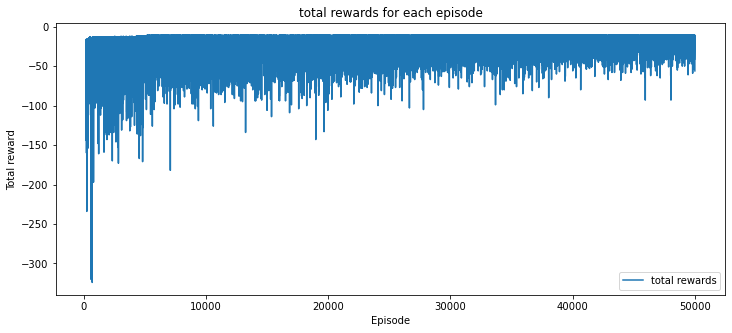

In [61]:
iters = [iter for iter in range(200, episode_num + 1)]
# iters = [iter for iter in range(episode_num)]
plt.figure(figsize=(12, 5))
plt.plot(iters, episode_rewards[199:], label='total rewards')
plt.title('total rewards for each episode')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.legend();
plt.savefig('rewards_episode')

### 6 More experiments

In [68]:
# when the car hit the wall, negative reward -100 will be return.

class Env_racetrack_v2:
    
    # Environment state space: all ([x, y], [v_x, v_y]) combination
    # [x, y] is a cell on our racetrack
    # under the cell [x,y], [v_x, v_y] is horizontal and vertical velocity for the agent racecar

    def __init__(self, course):

        #course is a List of text strings used to construct racetrack
        self.start_positions = []
        
        self.course = None
        self.load_course(course)
#         self._random_start_position()
   
    
    def random_start_position(self):
        
        # randomly choose start position on start line
        self.position = np.array(random.choice(self.start_positions),
                                dtype=np.int16)
   

    def reset(self):
        
        # initialize the racecar agent in the start line with v_x = 0 and v_y = 0
        self.random_start_position()
        self.velocity = np.array([0, 0], dtype=np.int16)
    
    
    def take_action(self, action):
        
        # take action to update current velocity and current state
        if self.is_terminal_state():
            # if we already cross the finish line, return reward 0
            return 0
        elif self.is_wall_state():
            # if hit the wall, retrun reward -100
            self.random_start_position()
            self.velocity = np.array([0, 0], dtype=np.int16)
            return -100
        
        self.update_velocity(action)
        self.update_position()
        
        # environment return reward to an action, always -1
        return -1
    
    
    def get_state(self):
        
        #after take action to the environment, environment could return new state
        # Return 2-tuple: (position, velocity). Each is a 2D numpy array.
        return (self.position.copy(), self.velocity.copy())
    
    
    def update_velocity(self, action):
        
        # new velocity: [v_x + a_x, v_y + a_y]
        self.velocity += np.array(action, dtype=np.int16)
    
    
    def update_position(self):
        # Update position based on the new velocity
        # Check at each cell from the current position to the update position 
        # If wall is hit, set position to random position at start line 
        # If finish line is crossed, set position to intersect point on finish line.
        max_velocity = 4
        for tstep in range(0, max_velocity+1):
            t = tstep / max_velocity
            pos = self.position + np.round(self.velocity * t).astype(np.int16)
#             if self.is_hit_wall(pos):
#                 self.random_start_position()
#                 self.velocity = np.array([0, 0], dtype=np.int16)
#                 return
            if self.is_hit_wall(pos) or self.is_cross_finish(pos):
                self.position = pos
                self.velocity = np.array([0, 0], dtype=np.int16) # terminal stop
                return
        self.position = pos
     
    
    def load_course(self, course):
        # Load course. Internally represented as numpy array
        y_size, x_size = len(course), len(course[0])
        self.course = np.zeros((x_size, y_size), dtype=np.int16)
        for y in range(y_size):
            for x in range(x_size):
                point = course[y][x]
                if point == 'o':
                    self.course[x, y] = 1
                elif point == '-':
                    self.course[x, y] = 0
                elif point == '+':
                    self.course[x, y] = 2
                elif point == 'W':
                    self.course[x, y] = -1
        # flip left/right so (0,0) is in bottom-left corner
        self.course = np.fliplr(self.course)
        for y in range(y_size):
            for x in range(x_size):
                if self.course[x, y] == 0:
                    self.start_positions.append((x, y))
                    

    def is_hit_wall(self, pos):
        # Return True if position is wall
        return self.course[pos[0], pos[1]] == -1
        

    def is_cross_finish(self, pos):
        # Return True if position is finish line        
        return self.course[pos[0], pos[1]] == 2
    

    def is_terminal_state(self):
        # Return True at episode terminal state
        return (self.course[self.position[0], self.position[1]] == 2)
    
    def is_wall_state(self):
        # Return True at episode terminal state
        return (self.course[self.position[0], self.position[1]] == -1)

In [69]:
def off_policy_MC_control_v2(course, epsilon, episode_num, gamma=1):

    x_size, y_size = len(course[0]), len(course)

    # initialize Q to large negative - otherwise too much exploration
    # 5x5 is dimension of velocity, 3x3 is dimension of action
    Q = np.zeros((x_size, y_size, 5, 5, 3, 3)) - 60 
    C = np.zeros((x_size, y_size, 5, 5, 3, 3)) 
    # pi is our target policy, which is to be improved to optimal one
    pi = np.random.randint(9, size=(x_size, y_size, 5, 5), dtype=np.int16) # randomly initialize target policy pi
    episode_rewards = []

    # generate track, racer object
    track = Env_racetrack_v2(course)
    racer = Agent_racer()

    for e in range(episode_num):
        
        total_reward = 0
        # generate episode following the behavior policy b
        track.reset()
        epi_path = [] # (S0,A0,prob_A0,R1),(S1,A1,prob_A1,R2) ..., RT. prob_A is for update W
        
        while not track.is_terminal_state():
            s = track.get_state()
            s_x, s_y = s[0][0], s[0][1] # current position
            s_vx, s_vy = s[1][0], s[1][1] # current velocity
            
            # follow behavior policy b
            greedy_action = pi[s_x, s_y, s_vx, s_vy]
            a, prob_a = racer.epsilon_greedy_policy((s_vx, s_vy), greedy_action, epsilon)       
        
            r = track.take_action(a)
            total_reward = total_reward + r
            
            epi_path.append((s, a, prob_a, r)) 
            
        episode_rewards.append(total_reward)                
        # update target policy and its Q table
        G = 0
        W = 1
        while len(epi_path) > 0:
            (s, a, prob_a, r) = epi_path.pop() # last in first out
            s_x, s_y = s[0][0], s[0][1]
            s_vx, s_vy = s[1][0], s[1][1]
            a_x, a_y = a
            s_a = (s_x, s_y, s_vx, s_vy, a_x, a_y) #index for state, action combination
            
            G = gamma * G + r
            C[s_a] += W
            Q[s_a] += W / C[s_a] * (G - Q[s_a]) # update Q for target policy with weighted ratio
            
            q_max = -1e6 # initialize a negative impossible Q value
            a_max = -1 # initialize an impossible greedy action 
            for i in range(9):  # given state, find an action that make the Q[s_a] be maximum
                act = racer.map_to_2D(i)
                s_a_max = (s_x, s_y, s_vx, s_vy, act[0], act[1])
                if a_max == -1 or Q[s_a_max] > q_max:
                    a_max = i
                    q_max = Q[s_a_max]
                    
            pi[s_x, s_y, s_vx, s_vy] = a_max # target pi store 1-D action with max Q value
            if pi[s_x, s_y, s_vx, s_vy] != racer.map_to_1D(a):
                break
            else:
                W *= 1/prob_a
                
    
    
    return pi, track, racer, episode_rewards

In [70]:
# setting parameters
course = racetrack_course
epsilon = 0.1
episode_num = 10000
gamma = 0.9

pi, track, racer, episode_rewards = off_policy_MC_control_v2(course, epsilon, episode_num, gamma=gamma)

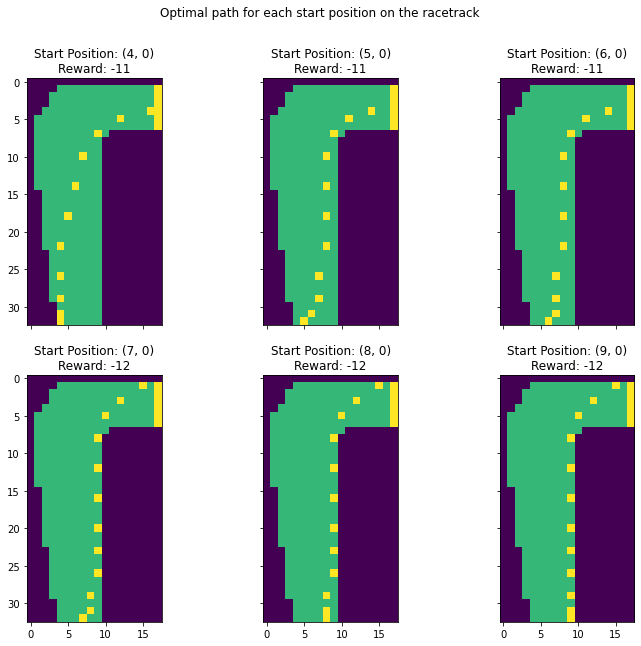

In [71]:
course = racetrack_course
x_size, y_size = len(course[0]), len(course)

fig, ax = plt.subplots(nrows=2, ncols=3, 
                       sharex=True, sharey=True,
                       figsize=(12,10))

for i,start_pos in enumerate(track.start_positions):
    G = 0 # total reward
    track.reset() 
    track.position = np.array(start_pos, dtype=np.int16) # set position to start_pos
    pos_map = np.zeros((x_size, y_size))
    # set all start positions to 1 instead of 0, for plotting purpose
    for x, y in [[x[0],x[1]] for x in track.start_positions]:
        pos_map[x, y] = 1

    for e in range(1000):
        s = track.get_state()
        s_x, s_y = s[0][0], s[0][1]
        s_vx, s_vy = s[1][0], s[1][1]
        pos_map[s_x, s_y] += 1  # mark path
        act = racer.map_to_2D(pi[s_x, s_y, s_vx, s_vy])
        G += track.take_action(act)
        if track.is_terminal_state(): break         
    pos_map +=  track.course  # overlay with track course

    # 6 start positions: 2 row and 3 column
    row = i//3
    col = i%3
    # choose cmap from: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    ax[row,col].imshow(np.flipud(pos_map.T), interpolation="nearest") 
    ax[row,col].set_title("Start Position: {}\nReward: {}".format(start_pos, G))
    fig.suptitle("Optimal path for each start position on the racetrack")

# fig.savefig("wall_10000_random_pi.jpeg")